In [1]:
import cv2
import torch
import numpy as np
import requests
from PIL import Image
from transformers import DPTImageProcessor, DPTForDepthEstimation
import matplotlib.pyplot as plt
import warnings

c:\Users\harsh\miniconda3\envs\ml-depth-pro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
MODEL_NAME = "Intel/dpt-hybrid-midas" # "Intel/dpt-large" Or "Intel/dpt-hybrid-midas", etc.
IMAGE_PATH = r"C:\Users\harsh\Downloads\PXL_20250418_052835918.jpg" # <-- CHANGE THIS - Needs an image from Pixel 6a with the reference object

KNOWN_FOCAL_LENGTH_PIXELS = 3031
KNOWN_OBJECT_WIDTH_METERS = 0.0856 # Standard ID-1 card width
# KNOWN_OBJECT_HEIGHT_METERS = 0.05398 # Standard ID-1 card height

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
try:
    processor = DPTImageProcessor.from_pretrained(MODEL_NAME)
    model = DPTForDepthEstimation.from_pretrained(MODEL_NAME)
    model.to(device)
    model.eval()
except Exception as e:
    print(f"Error loading model/processor: {e}")
    exit()

In [4]:
try:
    if 'IMAGE_PATH' in locals() and IMAGE_PATH:
        image_pil = Image.open(IMAGE_PATH).convert("RGB")
    else:
        raise ValueError("No image path specified")

    original_width, original_height = image_pil.size
    image_display_bgr = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR) # OpenCV uses BGR
    print(f"Loaded image with size: {original_width}x{original_height}")
    # --- Verification ---
    if original_width != 4032 or original_height != 3024:
        warnings.warn(
            f"WARNING: Image resolution is {original_width}x{original_height}, "
            f"but focal length {KNOWN_FOCAL_LENGTH_PIXELS}px was estimated for 4032x3024. "
            f"The calculated absolute depth scale may be inaccurate. "
            f"Consider adjusting KNOWN_FOCAL_LENGTH_PIXELS proportionally "
            f"or using an image at the target resolution.", UserWarning
            )

except FileNotFoundError:
    print(f"Error: Image file not found at {IMAGE_PATH}")
    exit()
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

Loaded image with size: 2688x1512


C:\Users\harsh\AppData\Local\Temp\ipykernel_9152\2428526654.py:12: UserWarning: WARNING: Image resolution is 2688x1512, but focal length 3031px was estimated for 4032x3024. The calculated absolute depth scale may be inaccurate. Consider adjusting KNOWN_FOCAL_LENGTH_PIXELS proportionally or using an image at the target resolution.
  warnings.warn(


In [5]:
inputs = processor(images=image_pil, return_tensors="pt")
pixel_values = inputs.pixel_values.to(device)

In [7]:
with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth

prediction_resized = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image_pil.size[::-1], # (height, width)
    mode="bilinear",
    align_corners=False,
)
relative_depth_map = prediction_resized.squeeze().cpu().numpy()

In [9]:
cv2.namedWindow("Select Reference Object", cv2.WINDOW_NORMAL)
preview_width = min(1280, original_width)
preview_height = int(preview_width * (original_height / original_width))
cv2.resizeWindow("Select Reference Object", preview_width, preview_height)

roi = cv2.selectROI("Select Reference Object", image_display_bgr, fromCenter=False, showCrosshair=True)
cv2.destroyWindow("Select Reference Object")

if roi == (0, 0, 0, 0): # Check if selection was cancelled or invalid
    print("ROI selection cancelled or invalid. Exiting.")
    exit()

x, y, w, h = roi
print(f"Selected ROI: x={x}, y={y}, width={w}, height={h}")

if w == 0 or h == 0:
     print("Selected ROI has zero width or height. Exiting.")
     exit()

Selected ROI: x=210, y=892, width=706, height=364


In [10]:
# 1. Measure Object Size in Pixels (Using ROI width here, matching KNOWN_OBJECT_WIDTH_METERS)
object_size_pixels = w
print(f"Measured object width in image: {object_size_pixels} pixels")
if object_size_pixels <= 0:
    print("Error: Object size in pixels is zero or negative.")
    exit()

# 2. Get Average Relative Depth within the ROI
roi_depth = relative_depth_map[y:y+h, x:x+w]
if roi_depth.size == 0:
    print("Error: Could not extract depth values from the ROI. Is ROI valid?")
    exit()

Measured object width in image: 706 pixels


In [11]:
d_relative_object = np.median(roi_depth)
print(f"Median relative depth of the object: {d_relative_object:.4f}")

if d_relative_object <= 1e-6:
    print("Error: Relative depth of the object is too small or zero.")
    exit()


scale_factor = (KNOWN_OBJECT_WIDTH_METERS * KNOWN_FOCAL_LENGTH_PIXELS * d_relative_object) / object_size_pixels
print(f"Calculated Scale Factor: {scale_factor:.4f}")

estimated_distance = scale_factor / d_relative_object
print(f"Estimated distance to the reference object: {estimated_distance:.2f} meters")

Median relative depth of the object: 1766.8582
Calculated Scale Factor: 649.3169
Estimated distance to the reference object: 0.37 meters


In [15]:
def detect_objects_from_depth_gradients_improved(depth_map, gradient_threshold=0.05, 
                                               blur_kernel_size=5, edge_closing_size=5,
                                               post_dilation_size=3, min_object_size=500, 
                                               padding_ratio=0.05, max_objects=5, 
                                               return_debug_info=False):
    """
    Enhanced detection of objects from a depth map using gradient information with
    improved edge closing and bounding box refinement.
    
    Args:
        depth_map: 2D numpy array of depth values
        gradient_threshold: Threshold for detecting significant depth changes
        blur_kernel_size: Size of the kernel for smoothing the depth map
        edge_closing_size: Size of the kernel for morphological closing of edges
        post_dilation_size: Size of the kernel for dilating object masks
        min_object_size: Minimum object size in pixels
        padding_ratio: Ratio to pad the detected bounding boxes
        max_objects: Maximum number of objects to detect
        return_debug_info: Return additional debug information
        
    Returns:
        list: List of ((x1, y1), (x2, y2)) bounding box coordinates for detected objects
        dict: Debug information if return_debug_info is True
    """
    import cv2
    import numpy as np
    from skimage import measure
    
    # Helper function to process depth map
    def preprocess_depth_map(depth_map):
        # Handle invalid values
        valid_mask = ~np.isnan(depth_map) & (depth_map > 0)
        if not np.any(valid_mask):
            return None, valid_mask
        
        # Normalize to [0, 1]
        depth_norm = depth_map.copy()
        min_depth = np.min(depth_norm[valid_mask])
        max_depth = np.max(depth_norm[valid_mask])
        
        if max_depth > min_depth:
            depth_norm = (depth_norm - min_depth) / (max_depth - min_depth)
        else:
            depth_norm = np.zeros_like(depth_norm)
            
        depth_norm[~valid_mask] = 0
        
        return depth_norm, valid_mask
    
    # Preprocess depth map
    depth_norm, valid_mask = preprocess_depth_map(depth_map)
    if depth_norm is None:
        return [] if not return_debug_info else ([], {})
    
    # Convert to uint8 for OpenCV operations
    depth_uint8 = (depth_norm * 255).astype(np.uint8)
    
    # Apply Gaussian blur to reduce noise
    depth_blur = cv2.GaussianBlur(depth_uint8, (blur_kernel_size, blur_kernel_size), 0)
    
    # Calculate depth gradients using Sobel
    grad_x = cv2.Sobel(depth_blur, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(depth_blur, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Normalize gradient magnitude
    if np.max(gradient_magnitude) > 0:
        gradient_magnitude = gradient_magnitude / np.max(gradient_magnitude)
    
    # Threshold gradient magnitude to get edges
    edges = (gradient_magnitude > gradient_threshold).astype(np.uint8) * 255
    
    # Apply morphological closing to connect nearby edges
    if edge_closing_size > 0:
        kernel_close = np.ones((edge_closing_size, edge_closing_size), np.uint8)
        edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_close)
    else:
        edges_closed = edges
    
    # Additional morphological operations to improve edge quality
    kernel_small = np.ones((3, 3), np.uint8)
    edges_processed = cv2.dilate(edges_closed, kernel_small, iterations=1)
    
    # Apply Canny edge detection to further refine edges
    edges_canny = cv2.Canny(depth_blur, 30, 90)
    
    # Combine both edge detection methods
    combined_edges = cv2.bitwise_or(edges_processed, edges_canny)
    
    # Create a contiguous boundary by finding contours and drawing them
    contours, _ = cv2.findContours(combined_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    edge_drawing = np.zeros_like(combined_edges)
    cv2.drawContours(edge_drawing, contours, -1, 255, 1)
    
    # Apply morphological operations to ensure closed boundaries
    kernel_dilate = np.ones((3, 3), np.uint8)
    edge_dilated = cv2.dilate(edge_drawing, kernel_dilate, iterations=2)
    
    # Invert edges to get potential object regions
    object_regions = 255 - edge_dilated
    
    # Find connected components
    labeled_regions = measure.label(object_regions, connectivity=2)
    region_properties = measure.regionprops(labeled_regions)
    
    # Filter regions by size and sort by mean depth
    valid_regions = []
    for region in region_properties:
        if region.area > min_object_size:
            # Calculate region mask
            region_mask = (labeled_regions == region.label)
            
            # If we have post-processing dilation
            if post_dilation_size > 0:
                dilate_kernel = np.ones((post_dilation_size, post_dilation_size), np.uint8)
                mask_dilated = cv2.dilate(region_mask.astype(np.uint8) * 255, dilate_kernel)
                region_mask = mask_dilated > 0
            
            # Calculate mean depth for this region (only valid pixels)
            depth_pixels = depth_map[region_mask & valid_mask]
            if len(depth_pixels) > 0:
                mean_depth = np.mean(depth_pixels)
            else:
                continue
                
            min_row, min_col, max_row, max_col = region.bbox
            
            valid_regions.append({
                'label': region.label,
                'bbox': (min_row, min_col, max_row, max_col),
                'mean_depth': mean_depth,
                'mask': region_mask
            })
    
    # If no valid regions found, try alternative approach with depth thresholding
    if not valid_regions:
        # Find the foreground based on depth thresholding
        if np.any(valid_mask):
            min_depth = np.min(depth_map[valid_mask])
            foreground_threshold = min_depth * 1.05  # 5% threshold
            foreground_mask = (depth_map <= foreground_threshold) & valid_mask
            
            # Label connected components
            labeled_foreground = measure.label(foreground_mask, connectivity=2)
            foreground_properties = measure.regionprops(labeled_foreground)
            
            for region in foreground_properties:
                if region.area > min_object_size:
                    min_row, min_col, max_row, max_col = region.bbox
                    region_mask = (labeled_foreground == region.label)
                    mean_depth = np.mean(depth_map[region_mask])
                    
                    valid_regions.append({
                        'label': region.label,
                        'bbox': (min_row, min_col, max_row, max_col),
                        'mean_depth': mean_depth,
                        'mask': region_mask
                    })
    
    # Sort regions by mean depth (closest first)
    valid_regions.sort(key=lambda x: x['mean_depth'])
    
    # Keep only the specified maximum number of objects
    valid_regions = valid_regions[:max_objects]
    
    # Apply padding to bounding boxes
    height, width = depth_map.shape
    padded_boxes = []
    
    for region in valid_regions:
        min_row, min_col, max_row, max_col = region['bbox']
        
        # Calculate padding
        h_pad = int((max_row - min_row) * padding_ratio)
        w_pad = int((max_col - min_col) * padding_ratio)
        
        # Apply padding with bounds checking
        min_row = max(0, min_row - h_pad)
        min_col = max(0, min_col - w_pad)
        max_row = min(height, max_row + h_pad)
        max_col = min(width, max_col + w_pad)
        
        # Convert to ((x1, y1), (x2, y2)) format
        padded_boxes.append(((min_col, min_row), (max_col, max_row)))
    
    if return_debug_info:
        debug_info = {
            'gradient_magnitude': gradient_magnitude,
            'edges': edges,
            'edges_closed': edges_closed,
            'edges_processed': edges_processed,
            'edges_canny': edges_canny,
            'combined_edges': combined_edges,
            'edge_drawing': edge_drawing,
            'object_regions': object_regions,
            'labeled_regions': labeled_regions
        }
        return padded_boxes, debug_info
    else:
        return padded_boxes


def detect_objects_by_depth_thresholding(depth_map, threshold_factor=1.05, min_object_size=500,
                                       padding_ratio=0.05, max_objects=5, return_mask=False):
    """
    Alternative approach: Detect objects by thresholding based on depth values.
    This is particularly useful for scenes where objects are clearly separated by depth.
    
    Args:
        depth_map: 2D numpy array of depth values
        threshold_factor: Factor to determine the depth threshold from minimum depth
        min_object_size: Minimum object size in pixels
        padding_ratio: Ratio to pad the bounding boxes
        max_objects: Maximum number of objects to return
        return_mask: Whether to return the object mask
        
    Returns:
        list: List of ((x1, y1), (x2, y2)) bounding box coordinates
        If return_mask is True, also returns the object mask
    """
    import cv2
    import numpy as np
    from skimage import measure
    
    # Handle invalid depth values
    valid_mask = ~np.isnan(depth_map) & (depth_map > 0)
    if not np.any(valid_mask):
        return [] if not return_mask else ([], None)
    
    # Find minimum depth (closest object)
    min_depth = np.min(depth_map[valid_mask])
    
    # Set threshold for foreground objects
    depth_threshold = min_depth * threshold_factor
    
    # Create foreground mask
    foreground_mask = (depth_map <= depth_threshold) & valid_mask
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    foreground_mask_processed = cv2.morphologyEx(
        foreground_mask.astype(np.uint8) * 255, 
        cv2.MORPH_CLOSE, 
        kernel
    )
    
    # Label connected components
    labeled_mask = measure.label(foreground_mask_processed, connectivity=2)
    region_properties = measure.regionprops(labeled_mask)
    
    # Filter regions by size and extract bounding boxes
    height, width = depth_map.shape
    bounding_boxes = []
    valid_masks = []
    
    for region in region_properties:
        if region.area >= min_object_size:
            min_row, min_col, max_row, max_col = region.bbox
            
            # Calculate padding
            h_pad = int((max_row - min_row) * padding_ratio)
            w_pad = int((max_col - min_col) * padding_ratio)
            
            # Apply padding with bounds checking
            min_row = max(0, min_row - h_pad)
            min_col = max(0, min_col - w_pad)
            max_row = min(height, max_row + h_pad)
            max_col = min(width, max_col + w_pad)
            
            # Calculate mean depth for sorting
            region_mask = labeled_mask == region.label
            mean_depth = np.mean(depth_map[region_mask & valid_mask])
            
            bounding_boxes.append({
                'bbox': ((min_col, min_row), (max_col, max_row)),
                'mean_depth': mean_depth,
                'mask': region_mask
            })
    
    # Sort by distance (closest first)
    bounding_boxes.sort(key=lambda x: x['mean_depth'])
    bounding_boxes = bounding_boxes[:max_objects]
    
    # Extract just the bounding boxes for return
    result_boxes = [box['bbox'] for box in bounding_boxes]
    
    if return_mask:
        # Combine masks of detected objects
        combined_mask = np.zeros_like(foreground_mask, dtype=bool)
        for box in bounding_boxes:
            combined_mask = combined_mask | box['mask']
        return result_boxes, combined_mask
    else:
        return result_boxes


def visualize_depth_detection_debug(depth_map, bounding_boxes, debug_info, 
                                  original_image=None, save_path=None):
    """
    Comprehensive visualization of depth-based object detection with debug information.
    
    Args:
        depth_map: Original depth map
        bounding_boxes: Detected bounding boxes
        debug_info: Dictionary of debug information from detection
        original_image: Optional original RGB image
        save_path: Path to save visualization
    """
    import matplotlib.pyplot as plt
    import cv2
    import numpy as np
    
    # Create a large figure for detailed visualization
    plt.figure(figsize=(20, 15))
    
    # Plot depth map
    plt.subplot(3, 3, 1)
    plt.imshow(depth_map, cmap='viridis')
    plt.title("Depth Map")
    plt.colorbar(label='Depth')
    plt.axis('off')
    
    # Plot gradient magnitude
    plt.subplot(3, 3, 2)
    plt.imshow(debug_info['gradient_magnitude'], cmap='hot')
    plt.title("Gradient Magnitude")
    plt.colorbar()
    plt.axis('off')
    
    # Plot raw edges
    plt.subplot(3, 3, 3)
    plt.imshow(debug_info['edges'], cmap='gray')
    plt.title("Raw Edges")
    plt.axis('off')
    
    # Plot closed edges
    plt.subplot(3, 3, 4)
    plt.imshow(debug_info['edges_closed'], cmap='gray')
    plt.title("Closed Edges")
    plt.axis('off')
    
    # Plot Canny edges
    plt.subplot(3, 3, 5)
    plt.imshow(debug_info['edges_canny'], cmap='gray')
    plt.title("Canny Edges")
    plt.axis('off')
    
    # Plot combined edges
    plt.subplot(3, 3, 6)
    plt.imshow(debug_info['combined_edges'], cmap='gray')
    plt.title("Combined Edges")
    plt.axis('off')
    
    # Plot edge drawing (contours)
    plt.subplot(3, 3, 7)
    plt.imshow(debug_info['edge_drawing'], cmap='gray')
    plt.title("Contour Drawing")
    plt.axis('off')
    
    # Plot object regions
    plt.subplot(3, 3, 8)
    plt.imshow(debug_info['object_regions'], cmap='gray')
    plt.title("Object Regions")
    plt.axis('off')
    
    # Plot final result with bounding boxes
    plt.subplot(3, 3, 9)
    
    if original_image is not None:
        vis_img = original_image.copy()
    else:
        # Visualize depth map in color
        depth_norm = depth_map.copy()
        valid_mask = ~np.isnan(depth_norm) & (depth_norm > 0)
        if np.any(valid_mask):
            min_depth = np.min(depth_norm[valid_mask])
            max_depth = np.max(depth_norm[valid_mask])
            if max_depth > min_depth:
                depth_norm = (depth_norm - min_depth) / (max_depth - min_depth)
            else:
                depth_norm = np.zeros_like(depth_norm)
            depth_norm[~valid_mask] = 0
            vis_img = cv2.applyColorMap((depth_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    # Draw bounding boxes
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
    
    for i, box in enumerate(bounding_boxes):
        (x1, y1), (x2, y2) = box
        color = colors[i % len(colors)]
        
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(vis_img, f"Object {i+1}", (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    if isinstance(vis_img, np.ndarray) and vis_img.shape[-1] == 3:
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(vis_img)
    plt.title("Final Detection")
    plt.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()


def multistage_object_detection(depth_map, original_image=None, max_objects=3,
                              return_all_methods=False, save_debug=False):
    """
    Combine multiple object detection methods for robust results.
    
    Args:
        depth_map: 2D numpy array of depth values
        original_image: Optional RGB image
        max_objects: Maximum number of objects to detect
        return_all_methods: Whether to return results from all methods
        save_debug: Whether to save debug visualizations
        
    Returns:
        List of bounding boxes or dictionary of all results if return_all_methods=True
    """
    import numpy as np
    
    # Method 1: Gradient-based detection with debug info
    gradient_boxes, debug_info = detect_objects_from_depth_gradients_improved(
        depth_map,
        gradient_threshold=0.03,  # More sensitive threshold
        blur_kernel_size=5,
        edge_closing_size=7,      # Larger closing to connect sparse edges
        post_dilation_size=5,     # Dilate object masks
        min_object_size=300,      # Smaller minimum size
        padding_ratio=0.1,        # Add 10% padding to boxes
        max_objects=max_objects,
        return_debug_info=True
    )
    
    # Method 2: Direct depth thresholding
    threshold_boxes, threshold_mask = detect_objects_by_depth_thresholding(
        depth_map,
        threshold_factor=1.1,     # Look for objects within 10% of minimum depth
        min_object_size=300,
        padding_ratio=0.1,
        max_objects=max_objects,
        return_mask=True
    )
    
    # If gradient method failed to find objects, use threshold method
    if not gradient_boxes and threshold_boxes:
        final_boxes = threshold_boxes
        detection_method = "threshold"
    else:
        final_boxes = gradient_boxes
        detection_method = "gradient"
    
    # If both methods failed, try one more approach: find just the closest point
    # and create a box around it
    if not final_boxes:
        valid_mask = ~np.isnan(depth_map) & (depth_map > 0)
        if np.any(valid_mask):
            min_depth = np.min(depth_map[valid_mask])
            y, x = np.where((depth_map == min_depth) & valid_mask)
            if len(y) > 0 and len(x) > 0:
                y, x = y[0], x[0]
                
                # Create a box around the closest point
                height, width = depth_map.shape
                box_size = min(width, height) // 4  # 1/4 of the smaller dimension
                
                x1 = max(0, x - box_size // 2)
                y1 = max(0, y - box_size // 2)
                x2 = min(width, x + box_size // 2)
                y2 = min(height, y + box_size // 2)
                
                final_boxes = [((x1, y1), (x2, y2))]
                detection_method = "closest_point"
    
    # Debug visualization if requested
    if save_debug:
        if detection_method == "gradient":
            visualize_depth_detection_debug(
                depth_map, final_boxes, debug_info, 
                original_image=original_image,
                save_path="depth_detection_debug.png"
            )
    
    if return_all_methods:
        return {
            'final_boxes': final_boxes,
            'gradient_boxes': gradient_boxes,
            'threshold_boxes': threshold_boxes,
            'detection_method': detection_method
        }
    else:
        return final_boxes

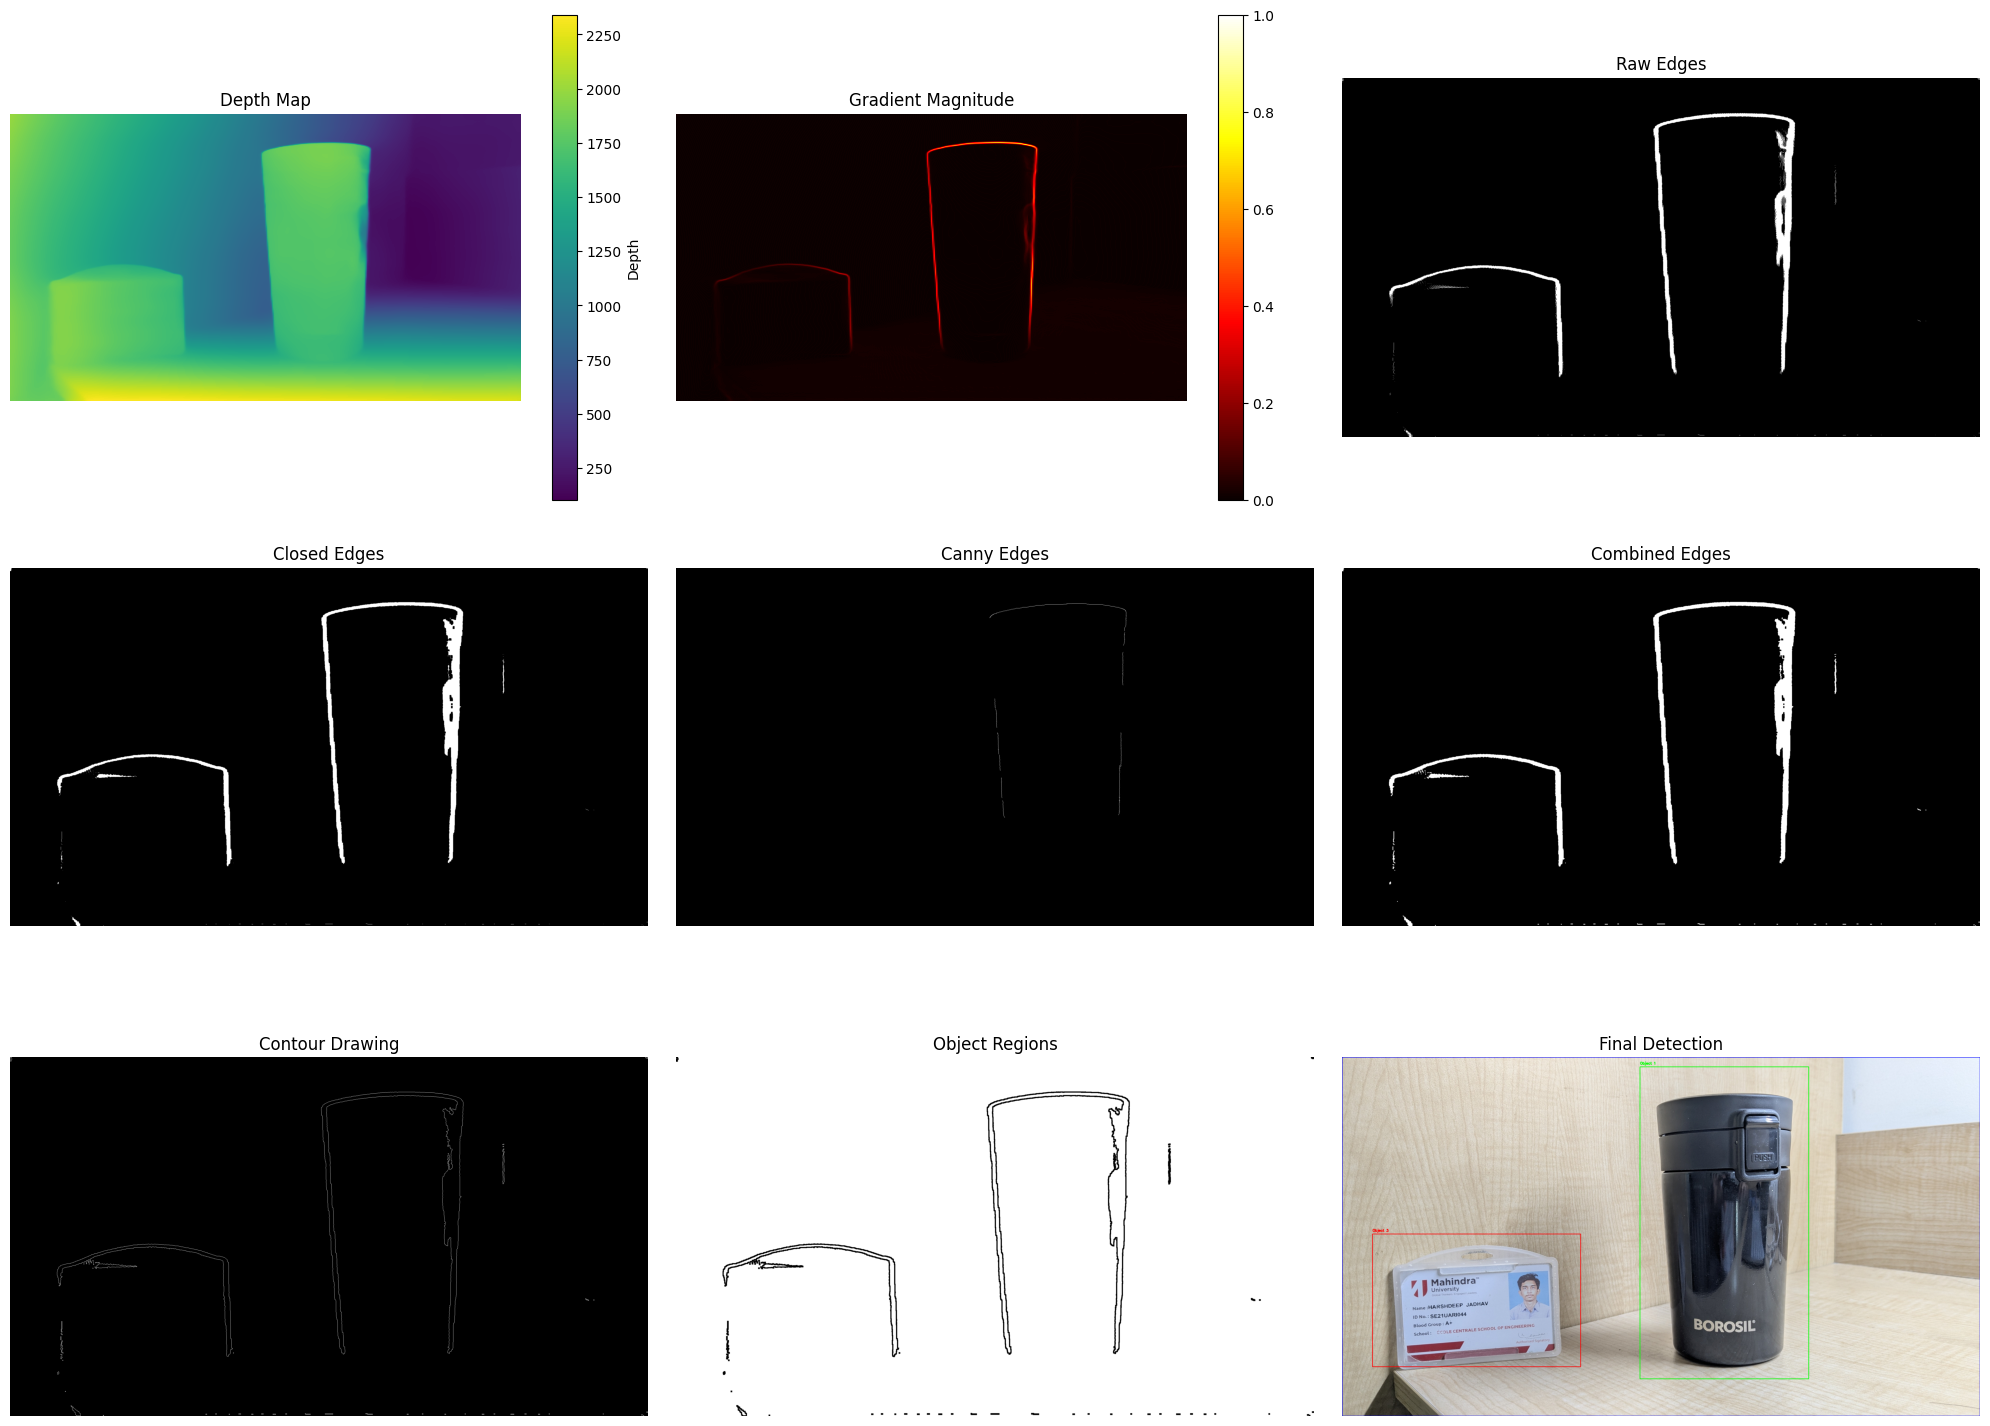

In [16]:
original_image = cv2.imread(IMAGE_PATH)
detection_results = multistage_object_detection(
        relative_depth_map,
        original_image=original_image,
        max_objects=3,
        return_all_methods=True,
        save_debug=True  # This will save detailed debugging visualization
    )

In [20]:
roi_coordinates = ((roi[0],roi[1]), (roi[0]+roi[2], roi[1]+roi[3])) 

In [25]:
def calculate_iou(box1, box2):
    # Get coordinates of the first box
    x1_1, y1_1 = box1[0]
    x2_1, y2_1 = box1[1]
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)

    # Get coordinates of the second box
    x1_2, y1_2 = box2[0]
    x2_2, y2_2 = box2[1]
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)

    # Calculate the coordinates of the intersection rectangle
    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)

    # If there is no intersection, IoU is 0
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate the area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of union
    union_area = area1 + area2 - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou



detection_results_boxes = detection_results['final_boxes']
roi_box = roi_coordinates

iou_scores = []
for det_box in detection_results_boxes:
    iou = calculate_iou(det_box, roi_box)
    iou_scores.append(iou)

print(iou_scores)

[0.0, 0.06323026895943562, 0.5241971838455624]


In [ ]:
import cv2
import os

# Desired scaling factor (e.g., 0.5 for half the size)
SCALE_FACTOR = 0.5
detection_results_boxes = detection_results['final_boxes']
roi_box = roi_coordinates
# Check if the image file exists
if not os.path.exists(IMAGE_PATH):
    print(f"Error: Image not found at {IMAGE_PATH}")
else:
    # Read the image using OpenCV
    try:
        image = cv2.imread(IMAGE_PATH)
        if image is None:
            print(f"Error: Could not read image at {IMAGE_PATH}")
        else:
            # Get the height and width of the image
            image_height, image_width, _ = image.shape

            # Calculate the new dimensions
            new_width = int(image_width * SCALE_FACTOR)
            new_height = int(image_height * SCALE_FACTOR)
            resized_image = cv2.resize(image, (new_width, new_height))

            # Adjust bounding box coordinates for the resized image
            def scale_box(box, original_width, original_height, new_width, new_height):
                x1 = int(box[0][0] * (new_width / original_width))
                y1 = int(box[0][1] * (new_height / original_height))
                x2 = int(box[1][0] * (new_width / original_width))
                y2 = int(box[1][1] * (new_height / original_height))
                return ((x1, y1), (x2, y2))

            scaled_detection_results_boxes = [
                scale_box(box, image_width, image_height, new_width, new_height)
                for box in detection_results['final_boxes']
            ]
            scaled_roi_box = scale_box(roi_coordinates, image_width, image_height, new_width, new_height)

            filtered_detection_results = []
            iou_scores = []

            for i, det_box in enumerate(detection_results['final_boxes']):
                iou = calculate_iou(det_box, roi_coordinates)
                iou_scores.append((iou, det_box, scaled_detection_results_boxes[i]))  # Store original and scaled

            # Sort the IoU scores in descending order to find the highest IoU
            iou_scores.sort(key=lambda item: item[0], reverse=True)

            # Identify the box with the highest IoU (using original coordinates)
            highest_iou_box_original = iou_scores[0][1] if iou_scores else None

            scaled_filtered_detection_results = []
            for i, det_box in enumerate(detection_results['final_boxes']):
                scaled_det_box = scaled_detection_results_boxes[i]
                # Check if the original box is NOT the one with the highest IoU
                if det_box != highest_iou_box_original:
                    # Check if the original coordinates are NOT equal to the image size
                    x1_orig, y1_orig = det_box[0]
                    x2_orig, y2_orig = det_box[1]
                    if not (x1_orig == 0 and y1_orig == 0 and x2_orig == image_width and y2_orig == image_height):
                        scaled_filtered_detection_results.append(scaled_det_box)

            print("Original detection results:", detection_results['final_boxes'])
            print("Highest IoU box (original):", highest_iou_box_original)
            print("Filtered detection results (original scale):", [item[1] for item in iou_scores if item[1] not in ([highest_iou_box_original] if highest_iou_box_original else []) and not (item[1][0][0] == 0 and item[1][0][1] == 0 and item[1][1][0] == image_width and item[1][1][1] == image_height)])
            print("Filtered detection results (scaled):", scaled_filtered_detection_results)

            # Draw filtered bounding boxes (e.g., in red) on the resized image
            image_with_filtered_boxes = resized_image.copy()
            for box in scaled_filtered_detection_results:
                start_point = (int(box[0][0]), int(box[0][1]))
                end_point = (int(box[1][0]), int(box[1][1]))
                color = (0, 0, 255)  # Red
                thickness = 2
                cv2.rectangle(image_with_filtered_boxes, start_point, end_point, color, thickness)

            # Draw the ROI bounding box (e.g., in blue) on the resized image
            roi_start_point = (int(scaled_roi_box[0][0]), int(scaled_roi_box[0][1]))
            roi_end_point = (int(scaled_roi_box[1][0]), int(scaled_roi_box[1][1]))
            roi_color = (255, 0, 0)  # Blue
            cv2.rectangle(image_with_filtered_boxes, roi_start_point, roi_end_point, roi_color, thickness)

            # Display the resized image with only the filtered bounding boxes
            cv2.imshow("Image with Filtered Boxes", image_with_filtered_boxes)
            cv2.waitKey(0)  # Wait until a key is pressed
            cv2.destroyAllWindows()  # Close all display windows

    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

Original detection results: [((1255, 41), (1966, 1355)), ((0, 0), (2688, 1512)), ((128, 745), (1005, 1304))]
Highest IoU box (original): ((128, 745), (1005, 1304))
Filtered detection results (original scale): [((1255, 41), (1966, 1355))]
Filtered detection results (scaled): [((627, 20), (983, 677))]


In [35]:
# %% [markdown]
# ### Calculate Depth of Objects in Filtered Bounding Boxes

# %%
def calculate_depth_in_bbox(depth_map, bbox, known_width, focal_length):
    """
    Calculates the estimated depth of an object within a bounding box.

    Args:
        depth_map (np.ndarray): The relative depth map.
        bbox (tuple): A tuple of ((x1, y1), (x2, y2)) representing the bounding box.
        known_width (float): The known width of the object in meters.
        focal_length (int): The focal length of the camera in pixels.

    Returns:
        float: The estimated depth of the object in meters, or None if calculation fails.
    """
    x1, y1 = bbox[0]
    x2, y2 = bbox[1]
    object_width_pixels = x2 - x1
    if object_width_pixels <= 0:
        print("Error: Object width in bounding box is zero or negative.")
        return None

    bbox_depth = depth_map[y1:y2, x1:x2]
    if bbox_depth.size == 0:
        print("Error: Could not extract depth values from the bounding box.")
        return None

    d_relative_object = np.median(bbox_depth)
    if d_relative_object <= 1e-6:
        print("Error: Relative depth in bounding box is too small or zero.")
        return None

    scale_factor = (known_width * focal_length * d_relative_object) / object_width_pixels
    estimated_distance = scale_factor / d_relative_object
    return estimated_distance

# %%
print("\n--- Estimated Depths of Filtered Objects ---")
final_depths = []
if scaled_filtered_detection_results:
    for i, filtered_bbox in enumerate(scaled_filtered_detection_results):
        # Use the original image dimensions for the depth map
        original_bbox_index = scaled_detection_results_boxes.index(filtered_bbox)
        original_bbox = detection_results['final_boxes'][original_bbox_index]

        depth = calculate_depth_in_bbox(
            relative_depth_map,
            original_bbox, # Use original scale bbox for depth calculation
            KNOWN_OBJECT_WIDTH_METERS,
            KNOWN_FOCAL_LENGTH_PIXELS
        )
        if depth is not None:
            final_depths.append(depth)
            print(f"Estimated depth of filtered object {i+1}: {depth:.2f} meters")
else:
    print("No filtered bounding boxes found.")

# You can now use the 'final_depths' list which contains the estimated
# depth for each of the filtered bounding boxes.


--- Estimated Depths of Filtered Objects ---
Estimated depth of filtered object 1: 0.36 meters


In [38]:
def calculate_real_world_dimensions(
    depth_meters, 
    bbox, 
    image_width, 
    image_height, 
    focal_length_pixels=None, 
    hfov_degrees=None, 
    vfov_degrees=None
):
    """
    Calculates the real-world dimensions of an object given its depth and bounding box.
    
    Args:
        depth_meters (float): The estimated depth of the object in meters.
        bbox (tuple): A tuple of ((x1, y1), (x2, y2)) representing the bounding box.
        image_width (int): Width of the image in pixels.
        image_height (int): Height of the image in pixels.
        focal_length_pixels (float, optional): Focal length of the camera in pixels.
        hfov_degrees (float, optional): Horizontal field of view in degrees.
        vfov_degrees (float, optional): Vertical field of view in degrees.
        
    Returns:
        tuple: (width_meters, height_meters) representing the dimensions of the object in meters.
    """
    # Extract bounding box coordinates
    (x1, y1), (x2, y2) = bbox
    
    # Calculate width and height in pixels
    width_pixels = x2 - x1
    height_pixels = y2 - y1
    
    # Method 1: Using focal length (if provided)
    if focal_length_pixels is not None:
        # Calculate real-world width and height using similar triangles
        width_meters = (width_pixels * depth_meters) / focal_length_pixels
        height_meters = (height_pixels * depth_meters) / focal_length_pixels
    
    # Method 2: Using field of view (if provided)
    elif hfov_degrees is not None and vfov_degrees is not None:
        # Convert field of view from degrees to radians
        hfov_radians = math.radians(hfov_degrees)
        vfov_radians = math.radians(vfov_degrees)
        
        # Calculate the real-world width and height using field of view
        # Total field width at the object's depth
        total_width_at_depth = 2 * depth_meters * math.tan(hfov_radians / 2)
        total_height_at_depth = 2 * depth_meters * math.tan(vfov_radians / 2)
        
        # Calculate the object's dimensions based on its proportion of the image
        width_meters = (width_pixels / image_width) * total_width_at_depth
        height_meters = (height_pixels / image_height) * total_height_at_depth
    
    else:
        raise ValueError("Either focal_length_pixels or both hfov_degrees and vfov_degrees must be provided")
    
    return width_meters, height_meters

# Example usage:
# First, integrate with your existing detection pipeline
def analyze_detected_objects(
    depth_map, 
    detection_boxes, 
    image_width, 
    image_height, 
    focal_length_pixels=KNOWN_FOCAL_LENGTH_PIXELS, 
    known_width_meters=KNOWN_OBJECT_WIDTH_METERS,
    hfov_degrees=65.6,  # Example value, replace with actual camera HFOV
    vfov_degrees=51.6   # Example value, replace with actual camera VFOV
):
    """
    Analyzes detected objects to calculate their depths and real-world dimensions.
    
    Args:
        depth_map: The depth map from your depth estimation model
        detection_boxes: List of bounding boxes in the format ((x1, y1), (x2, y2))
        image_width: Width of the input image in pixels
        image_height: Height of the input image in pixels
        focal_length_pixels: Camera focal length in pixels
        known_width_meters: Width of the reference object in meters
        hfov_degrees: Horizontal field of view in degrees
        vfov_degrees: Vertical field of view in degrees
        
    Returns:
        list: List of dictionaries containing object information including dimensions
    """
    results = []
    
    for i, bbox in enumerate(detection_boxes):
        # Calculate depth using your existing function
        depth = calculate_depth_in_bbox(
            depth_map,
            bbox,
            known_width_meters,
            focal_length_pixels
        )
        
        if depth is not None:
            # Calculate dimensions using the new function
            width_meters, height_meters = calculate_real_world_dimensions(
                depth,
                bbox,
                image_width,
                image_height,
                focal_length_pixels=focal_length_pixels,
                hfov_degrees=hfov_degrees,
                vfov_degrees=vfov_degrees
            )
            
            # Store results
            results.append({
                'index': i,
                'bbox': bbox,
                'depth_meters': depth,
                'width_meters': width_meters,
                'height_meters': height_meters,
                'volume_cubic_meters': width_meters * height_meters * min(width_meters, height_meters)  # Approximate volume
            })
    
    return results

# Add this to your main script
import math

# Sample usage with the filtered detection results
if __name__ == "__main__" or True:  # True to run in Jupyter
    # Camera parameters - replace with actual values for your camera
    PIXEL_6A_HFOV_DEGREES = 78.0  # Example value for Pixel 6a
    PIXEL_6A_VFOV_DEGREES = 65.0  # Example value for Pixel 6a
    
    # Use the detection results from your previous code
    print("\n--- Object Dimensions Analysis ---")
    
    # Make sure to use original (unscaled) bounding boxes for dimension calculations
    filtered_original_boxes = []
    for scaled_box in scaled_filtered_detection_results:
        # Find the corresponding original box
        idx = scaled_detection_results_boxes.index(scaled_box)
        original_box = detection_results['final_boxes'][idx]
        filtered_original_boxes.append(original_box)
    
    # Analyze objects
    object_analysis = analyze_detected_objects(
        relative_depth_map,
        filtered_original_boxes,
        original_width,  # Original image width
        original_height, # Original image height
        focal_length_pixels=KNOWN_FOCAL_LENGTH_PIXELS,
        known_width_meters=KNOWN_OBJECT_WIDTH_METERS,
        hfov_degrees=PIXEL_6A_HFOV_DEGREES,
        vfov_degrees=PIXEL_6A_VFOV_DEGREES
    )
    
    # Display results
    for obj in object_analysis:
        print(f"\nObject {obj['index'] + 1}:")
        print(f"  Depth: {obj['depth_meters']:.2f} meters")
        print(f"  Width: {obj['width_meters']:.2f} meters ({obj['width_meters'] * 100:.1f} cm)")
        print(f"  Height: {obj['height_meters']:.2f} meters ({obj['height_meters'] * 100:.1f} cm)")
        print(f"  Estimated Volume: {obj['volume_cubic_meters']:.3f} cubic meters")
        
        # Convert to more human-friendly units if small
        if obj['width_meters'] < 0.1 and obj['height_meters'] < 0.1:
            print(f"  Width: {obj['width_meters'] * 1000:.1f} mm")
            print(f"  Height: {obj['height_meters'] * 1000:.1f} mm")
            
    # Visualize with dimensions
    def visualize_objects_with_dimensions(image, objects, scale_factor=1.0):
        """
        Visualizes detected objects with their dimensions on the image.
        
        Args:
            image: Original image
            objects: List of object analysis results
            scale_factor: Factor to scale the image and boxes
        """
        # Resize image if needed
        if scale_factor != 1.0:
            image = cv2.resize(image, (int(image.shape[1] * scale_factor), 
                                       int(image.shape[0] * scale_factor)))
        
        # Make a copy to draw on
        vis_img = image.copy()
        
        # Define colors for different objects
        colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), 
                 (255, 255, 0), (0, 255, 255), (255, 0, 255)]
        
        for i, obj in enumerate(objects):
            bbox = obj['bbox']
            # Scale box if needed
            if scale_factor != 1.0:
                x1, y1 = int(bbox[0][0] * scale_factor), int(bbox[0][1] * scale_factor)
                x2, y2 = int(bbox[1][0] * scale_factor), int(bbox[1][1] * scale_factor)
                bbox = ((x1, y1), (x2, y2))
            else:
                x1, y1 = bbox[0]
                x2, y2 = bbox[1]
            
            # Select color
            color = colors[i % len(colors)]
            
            # Draw rectangle
            cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
            
            # Format dimensions text
            dims_text = f"{obj['width_meters']*100:.1f}cm x {obj['height_meters']*100:.1f}cm"
            depth_text = f"Depth: {obj['depth_meters']:.2f}m"
            
            # Draw background for text
            text_size, _ = cv2.getTextSize(dims_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(vis_img, (x1, y1 - text_size[1] - 25), 
                         (x1 + text_size[0], y1), color, -1)
            
            # Draw text
            cv2.putText(vis_img, dims_text, (x1, y1 - 15), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            cv2.putText(vis_img, depth_text, (x1, y1 - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        
        # Display image
        cv2.imshow("Objects with Dimensions", vis_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        # Save image
        cv2.imwrite("objects_with_dimensions.jpg", vis_img)
        
    # Call visualization function
    visualize_objects_with_dimensions(original_image, object_analysis, scale_factor=SCALE_FACTOR)


--- Object Dimensions Analysis ---

Object 1:
  Depth: 0.36 meters
  Width: 0.09 meters (8.6 cm)
  Height: 0.16 meters (15.8 cm)
  Estimated Volume: 0.001 cubic meters
